<a href="https://colab.research.google.com/github/center4ml/Workshops/blob/2023_2/Day_3/20_training_FNO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import matplotlib.pyplot as plt

# Putting that all together

Now, recall the FNO architecture

![FNO architecture](https://i.imgur.com/muYkubI.png)

Note a few things, now:

1. The batch order is retained in the below version of the code.
1. Linear layers W (parallel to the Fourier layer) get defined by a two dimensional convolution with a few $1 \times 1$ kernels, as we explained it earlier. No doubt having channels first is a good enough reason to arrange things this way.
1. Padding of 9 zeros is added to the left and bottom of the input image (by default) to make the input more periodic. This step is not that clear to me.
1. GELU (Gaussian Error Linear Unit) is used as the non-linearity. Without going into details it looks like that (image from [this link](https://pub.towardsai.net/is-gelu-the-relu-successor-deep-learning-activations-7506cf96724f)):
![GELU](https://miro.medium.com/v2/resize:fit:786/format:webp/0*lpKy2FLJ8NV0QkGY)

## FNO2d class

In [4]:
"""

code adapted from from: https://github.com/khassibi/fourier-neural-operator/blob/main/fourier_2d.py


@original author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

################################################################
# fourier layer
################################################################
class SpectralConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = torch.nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = torch.nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(torch.nn.Module):
    def __init__(self, modes1, modes2,  hidden_width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.hidden_width = hidden_width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = torch.nn.Linear(3, self.hidden_width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.hidden_width, self.hidden_width, self.modes1, self.modes2)
        self.w0 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)
        self.w1 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)
        self.w2 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)
        self.w3 = torch.nn.Conv2d(self.hidden_width, self.hidden_width, 1)

        self.fc1 = torch.nn.Linear(self.hidden_width, 128)
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, x):
        # x                       # Batch, Height, Width, 3
        x = self.fc0(x)           # Batch, Height, Width, H
        x = x.permute(0, 3, 1, 2) # Batch, H, Height, Width
        x = torch.nn.functional.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)        # Batch, H, Height, Width
        x2 = self.w0(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width
        x = torch.nn.functional.gelu(x)

        x1 = self.conv1(x)        # Batch, H, Height, Width
        x2 = self.w1(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width
        x = torch.nn.functional.gelu(x)

        x1 = self.conv2(x)        # Batch, H, Height, Width
        x2 = self.w2(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width
        x = torch.nn.functional.gelu(x)

        x1 = self.conv3(x)        # Batch, H, Height, Width
        x2 = self.w3(x)           # Batch, H, Height, Width
        x = x1 + x2               # Batch, H, Height, Width

        if self.padding > 0:
          x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1) # Batch, Height, Width, H
        x = self.fc1(x)           # Batch, Height, Width, 128
        x = torch.nn.functional.gelu(x)
        x = self.fc2(x)           # Batch, Height, Width, 1
        return x

## Reading Data

Unfortunately we'll need rather heavy artilery only to read input and ground truth output data. The exemplary one item of the input data we worked with earlier, was taken from that source, too. I *copied-and-pasted* it. So we avoided using packaged code for now.

Unfortunately, we can't continue that way, we can't copy-paste the whole dataset. The data will come from the `neuraloperator` package which is an official codebase from the Kovachki lab: [neuraloperator GitHub page](https://github.com/neuraloperator/neuraloperator).

In [5]:
!pip install wandb
!pip install ruamel.yaml
!pip install configmypy
!pip install tensorly
!pip install tensorly-torch
!pip install torch-harmonics
!pip install matplotlib
!pip install opt-einsum
!pip install h5py
!pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.8 MB

In [6]:
!pip install neuraloperator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.7 MB/s eta 0:00:00


In [7]:
from neuralop.datasets import load_darcy_flow_small

sdf_train_loader, sdf_test_loaders, sdf_output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

train_samples_x = torch.permute(torch.stack([sdf_train_loader.dataset[i]['x'] for i in range(1000)]), (0, 2, 3 ,1))
test_samples_x =  torch.permute(torch.stack([sdf_test_loaders[16].dataset[i]['x'] for i in range(50)]), (0, 2, 3 ,1))
test_samples_x_32 =  torch.permute(torch.stack([sdf_test_loaders[32].dataset[i]['x'] for i in range(50)]), (0, 2, 3 ,1))

train_samples_y = torch.permute(torch.stack([sdf_train_loader.dataset[i]['y'] for i in range(1000)]), (0, 2, 3 ,1))
print("MEAN = ", torch.mean(train_samples_y), "SD = ", torch.std(train_samples_y))

test_samples_y =  torch.permute( torch.stack([sdf_test_loaders[16].dataset[i]['y'] for i in range(50)]), (0, 2, 3 ,1))
print("MEAN = ", torch.mean(test_samples_y), "SD = ", torch.std(test_samples_y))

test_samples_y_32 =  torch.permute( torch.stack([sdf_test_loaders[32].dataset[i]['y'] for i in range(50)]), (0, 2, 3 ,1))
print("MEAN = ", torch.mean(test_samples_y_32), "SD = ", torch.std(test_samples_y_32))


UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32
MEAN =  tensor(5.7220e-09) SD =  tensor(1.0000)
MEAN =  tensor(0.3985) SD =  tensor(0.3474)
MEAN =  tensor(0.4019) SD =  tensor(0.3437)


There is a problem with the underlying statistics between the train set and test set. We must make the underlying distributions the same

In [8]:
m_16=torch.mean(test_samples_y)
sd_16=torch.std(test_samples_y)

m_32=torch.mean(test_samples_y_32)
sd_32=torch.std(test_samples_y_32)

test_samples_y = (test_samples_y - m_16) / sd_16
test_samples_y_32 = (test_samples_y_32 - m_32) / sd_16

## Visualizing a few samples in input and output data


### Train and test data for 16x16 resolution

torch.Size([16, 16, 3])
torch.Size([16, 16, 1])


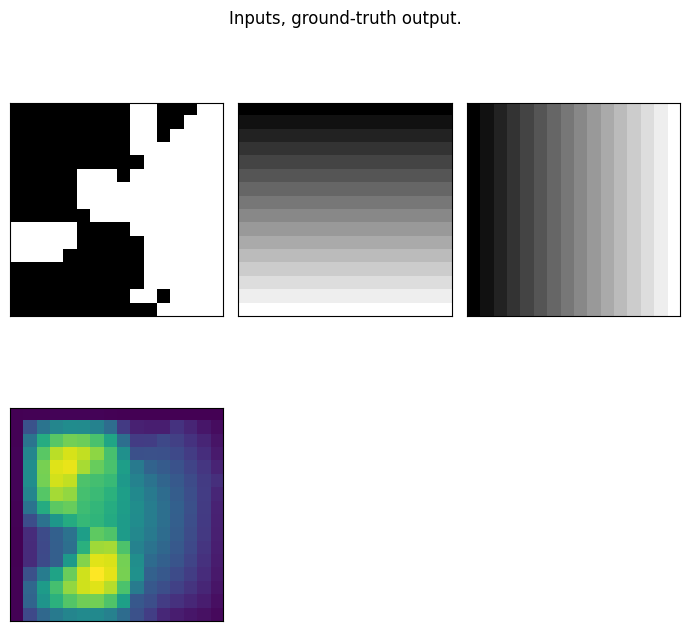

In [9]:
# adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py
fig = plt.figure(figsize=(7, 7))

x = test_samples_x[0]
print(x.size())

ax = fig.add_subplot(2, 3, 1)
ax.imshow(x.cpu()[:,:,0], cmap='gray')

plt.xticks([], [])
plt.yticks([], [])

ax = fig.add_subplot(2, 3, 2)
ax.imshow(x.cpu()[:,:,1], cmap='gray')

plt.xticks([], [])
plt.yticks([], [])

ax = fig.add_subplot(2, 3, 3)
ax.imshow(x.cpu()[:,:,2], cmap='gray')

plt.xticks([], [])
plt.yticks([], [])


# Ground-truth
y = test_samples_y[0]
print(y.size())
ax = fig.add_subplot(2, 3, 4)
ax.imshow(y.squeeze())
plt.xticks([], [])
plt.yticks([], [])


fig.suptitle('Inputs, ground-truth output.', y=0.98)
plt.tight_layout()
fig.show()


## Test data for 32x32 super-resolution

torch.Size([32, 32, 3])
torch.Size([32, 32, 1])


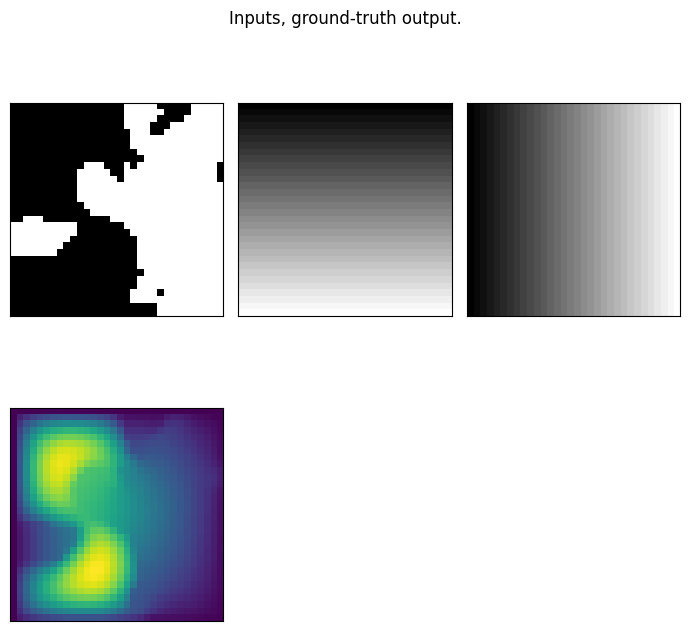

In [10]:
# adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py

fig = plt.figure(figsize=(7, 7))

x = test_samples_x_32[0]
print(x.size())

ax = fig.add_subplot(2, 3, 1)
ax.imshow(x.cpu()[:,:,0], cmap='gray')

plt.xticks([], [])
plt.yticks([], [])

ax = fig.add_subplot(2, 3, 2)
ax.imshow(x.cpu()[:,:,1], cmap='gray')

plt.xticks([], [])
plt.yticks([], [])

ax = fig.add_subplot(2, 3, 3)
ax.imshow(x.cpu()[:,:,2], cmap='gray')

plt.xticks([], [])
plt.yticks([], [])


# Ground-truth
y = test_samples_y_32[0]
print(y.size())
ax = fig.add_subplot(2, 3, 4)
ax.imshow(y.squeeze())
plt.xticks([], [])
plt.yticks([], [])


fig.suptitle('Inputs, ground-truth output.', y=0.98)
plt.tight_layout()
fig.show()

## Training our FNO

We'll use a training loop very similar to what we learned on the Day 1



In [11]:
################################################################
# configs
################################################################

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device available: %s"%device)

ntrain = 1000
ntest = 50

batch_size = 32
test_batch_size = 1
learning_rate = 0.01

epochs = 20
step_size = 100

modes = 9
hidden_width = 16

################################################################
# initializing model, data loaders and an optimizer
################################################################
model = FNO2d(modes, modes, hidden_width).to(device)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_samples_x, train_samples_y),
    batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_samples_x, test_samples_y),
    batch_size = test_batch_size, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=1e-4)

Device available: cpu


In [12]:
################################################################
# adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py
# plot input, predicted output and ground truth BEFORE training
################################################################
def plot_training_results(test_samples_x, test_samples_y, model, title = 'Inputs, ground-truth output and prediction'):

  model.eval()

  fig = plt.figure(figsize=(7, 7))
  for index in range(4):

      # Input x
      x = test_samples_x[index]

      # Ground-truth
      y = test_samples_y[index]

      # Model prediction
      out = model(x.to(device).unsqueeze(0))


      ax = fig.add_subplot(4, 4, index*4 + 1)
      ax.imshow(x.cpu()[:,:,0], cmap='gray')
      if index == 0:
          ax.set_title('Input x')
      plt.xticks([], [])
      plt.yticks([], [])


      ax = fig.add_subplot(4, 4, index*4 + 2)
      ax.imshow(y.squeeze())
      if index == 0:
          ax.set_title('Ground-truth y')
      plt.xticks([], [])
      plt.yticks([], [])

      ax = fig.add_subplot(4, 4, index*4 + 3)
      ax.imshow(out.squeeze().detach().cpu().numpy())
      if index == 0:
          ax.set_title('Model prediction')
      plt.xticks([], [])
      plt.yticks([], [])

      ax = fig.add_subplot(4, 4, index*4 + 4)
      ax.imshow(torch.abs((out.squeeze().detach().cpu()-y.squeeze())))
      ax.set_title('Difference, RMSE=%.4f'%torch.mean((out.squeeze().detach().cpu()-y.squeeze())**2).item()**.5)
      plt.xticks([], [])
      plt.yticks([], [])

  fig.suptitle(title, y=0.98)
  plt.tight_layout()
  fig.show()

Device used: cpu


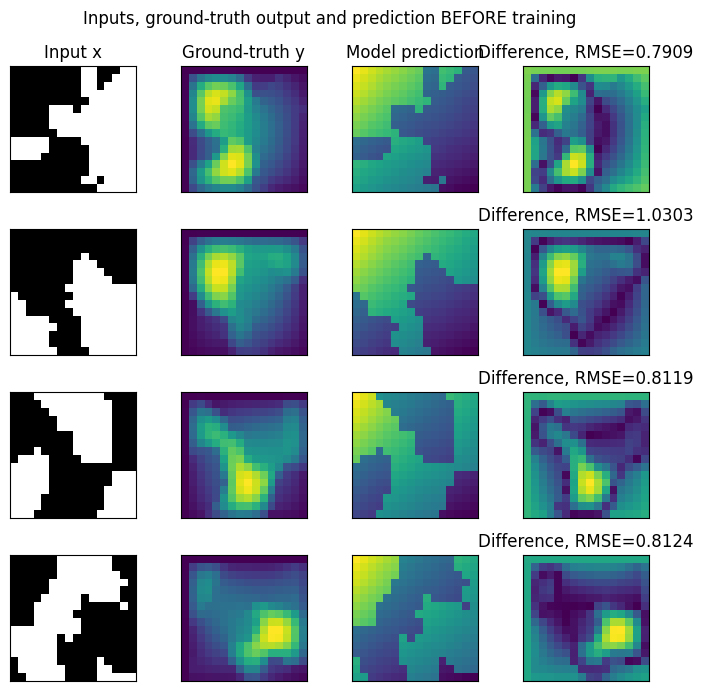

In [13]:
print("Device used: %s"%device)

plot_training_results(test_samples_x, test_samples_y, model, \
                      'Inputs, ground-truth output and prediction BEFORE training')

In [14]:
################################################################
# training loop
################################################################

print("Device used: %s"%device)

model.train()

for epoch in range(epochs):
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        out = model(x)

        breakpoint

        mse = torch.nn.functional.mse_loss(out, y, reduction='mean')
        epoch_loss += mse.item()

        mse.backward()
        optimizer.step()

    print("Epoch: %d with loss %.4f"%(epoch, epoch_loss))



Device used: cpu
Epoch: 0 with loss 13.6762
Epoch: 1 with loss 3.4268
Epoch: 2 with loss 2.4239
Epoch: 3 with loss 1.8443
Epoch: 4 with loss 1.7062
Epoch: 5 with loss 1.1692
Epoch: 6 with loss 0.8311
Epoch: 7 with loss 0.6611
Epoch: 8 with loss 0.5988
Epoch: 9 with loss 0.5099
Epoch: 10 with loss 0.4688
Epoch: 11 with loss 0.3687
Epoch: 12 with loss 0.3273
Epoch: 13 with loss 0.2980
Epoch: 14 with loss 0.2830
Epoch: 15 with loss 0.3713
Epoch: 16 with loss 0.4933
Epoch: 17 with loss 0.3626
Epoch: 18 with loss 0.3238
Epoch: 19 with loss 0.3463


## Visualizing the resulting predictions

Let's try to visually inspect the results.

Device used: cpu


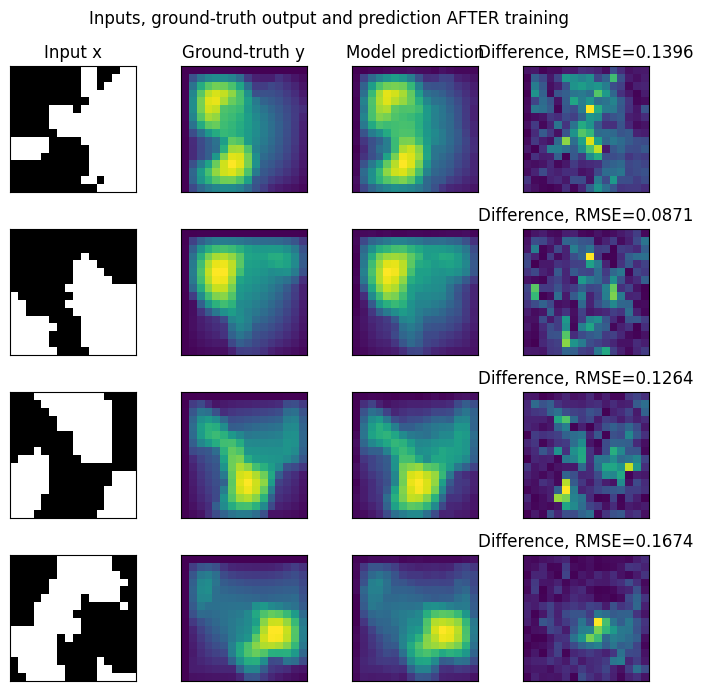

In [15]:
print("Device used: %s"%device)

plot_training_results(test_samples_x, test_samples_y, model, \
                      'Inputs, ground-truth output and prediction AFTER training')

## What about super-resolution?

Device used: cpu


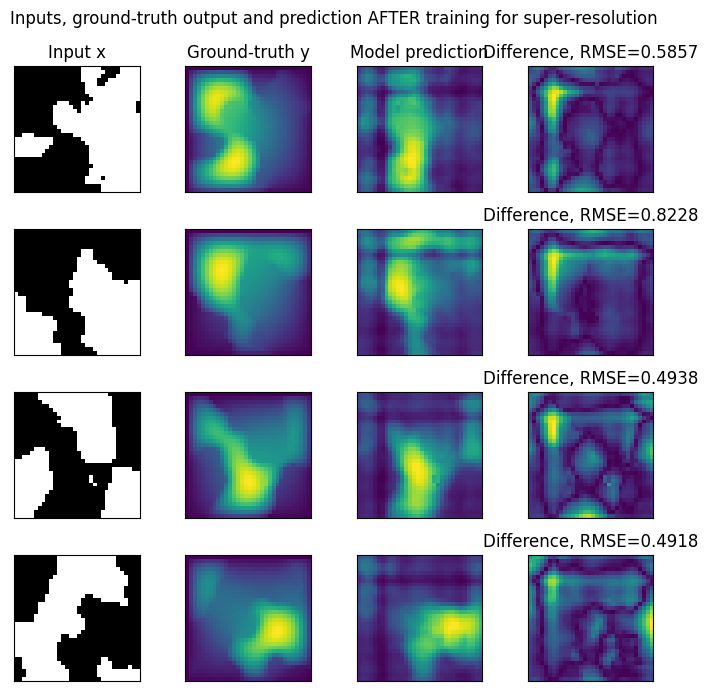

In [16]:
print("Device used: %s"%device)

plot_training_results(test_samples_x_32, test_samples_y_32, model,\
                      'Inputs, ground-truth output and prediction AFTER training for super-resolution')

Well, there is something wrong with the result.

## Visualizing the circular convolution weights for the trained network

Now, let's use the know-how on visualizing circular convolution weights for the first convolutional fourier layer. Recall it has 16 components (`model.hidden_width`) for each output channel. We'll be visualizing the 1st output channel, for the first convolutional layer, only.

In [18]:
Height = Width = 16

# first, initiate a H by Height by Width complex float Tensor with zeros
weights = torch.zeros((model.hidden_width, Height + model.padding, Width + model.padding), dtype = torch.cfloat)

# weights1, as you recall, relate to the lowest *positive* frequencies
weights[:, :model.modes1, :model.modes2] = model.conv0.weights1[:, 1]

# weights2, as you recall, relate to the lowest *negative* frequencies
weights[:, -model.modes1:, :model.modes2] = model.conv0.weights2[:, 1]

# add the conjugate-symmetric part
for r in range(Height + model.padding):
  for c in range((Width + model.padding) // 2 + 1, Width + model.padding):
    weights[:, r, c] = torch.conj(weights[:, (- r) % (Height + model.padding), (- c) % (Width + model.padding)])

# take the weights into the real domain
weights_inverse_transformed = torch.fft.ifft2(weights)

# additionally, drop the imaginary part
weights_inverse_transformed = torch.real(weights_inverse_transformed)

<Figure size 700x700 with 0 Axes>

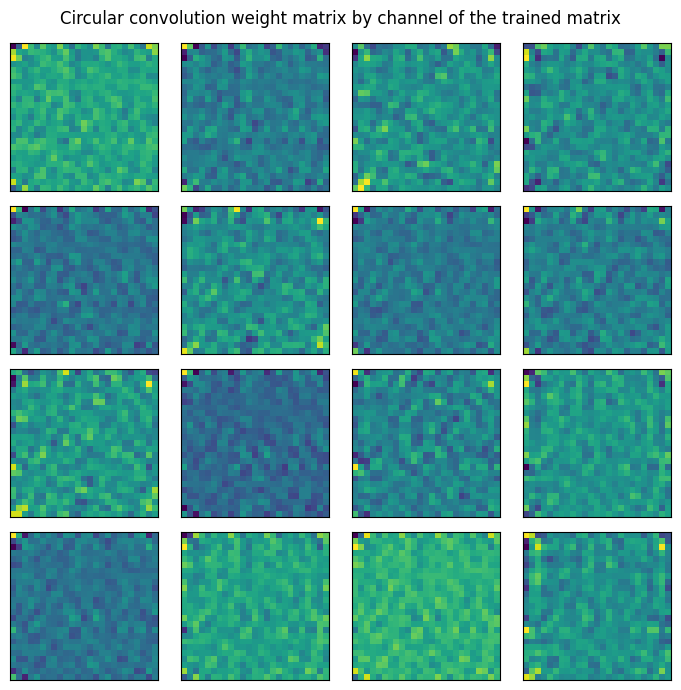

In [19]:
# adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py
fig = plt.figure(figsize=(7, 7))

weight_channel = weights_inverse_transformed.detach()


fig = plt.figure(figsize=(7, 7))
for r in range(4):
  for c in range(4):
    x = weight_channel[r * 4 + c]

    ax = fig.add_subplot(4, 4, r*4 + c + 1)
    ax.imshow(x.cpu()[:,:])
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Circular convolution weight matrix by channel of the trained matrix', y=0.98)
plt.tight_layout()
fig.show()

# Executing the [official implementation](https://github.com/neuraloperator/neuraloperator/) `Trainer.train` function

In [20]:
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params

In [21]:
"""
Training an FNO on Darcy-Flow

code adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py

=============================

In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package
to train a Fourier-Neural Operator
"""

print("Device used: %s\n"%device)

FNO_train_loader, FNO_test_loaders, FNO_output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)
# A careful reader will note that the input data in those files is organized
# BATCH, CHANNELS, HEIGHT, WIDTH


# We create FNO model
FNO_model = FNO(n_modes=(modes, modes), hidden_channels=hidden_width, projection_channels=64, factorization='tucker', rank=0.42)
FNO_model = FNO_model.to(device)

n_params = count_params(FNO_model)
print(f'\nOur model has {n_params} parameters.')

#Create the optimizer and scheduler
FNO_optimizer = torch.optim.Adam(FNO_model.parameters(), lr=0.01)
FNO_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(FNO_optimizer, T_max=30)

print('\n### MODEL ###\n', FNO_model)
print('\n### OPTIMIZER ###\n', FNO_optimizer)
print('\n### SCHEDULER ###\n', FNO_scheduler)

# Create the trainer
trainer = Trainer(FNO_model, n_epochs=20,
                  device=device,
                  wandb_log=False,
                  log_test_interval=2,
                  verbose=True)



# Actually train the model on our small Darcy-Flow dataset
trainer.train(FNO_train_loader, FNO_test_loaders,
              FNO_output_encoder,
              FNO_model,
              FNO_optimizer,
              FNO_scheduler,
              regularizer=False)



Device used: cpu

UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32

Our model has 29569 parameters.

### MODEL ###
 FNO(
  (fno_blocks): FNOBlocks(
    (convs): FactorizedSpectralConv(
      (weight): ModuleList(
        (0-7): 8 x ComplexTuckerTensor(shape=(16, 16, 4, 4), rank=(12, 12, 3, 3))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): Lifting(
    (fc): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection): Projection(
    (fc1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach

## Visual testing

Input tensor size: torch.Size([3, 16, 16])
Ground-truth tensor size: torch.Size([1, 16, 16])
Batched prediction size: torch.Size([1, 1, 16, 16])
Input tensor size: torch.Size([3, 16, 16])
Ground-truth tensor size: torch.Size([1, 16, 16])
Batched prediction size: torch.Size([1, 1, 16, 16])
Input tensor size: torch.Size([3, 16, 16])
Ground-truth tensor size: torch.Size([1, 16, 16])
Batched prediction size: torch.Size([1, 1, 16, 16])
Input tensor size: torch.Size([3, 16, 16])
Ground-truth tensor size: torch.Size([1, 16, 16])
Batched prediction size: torch.Size([1, 1, 16, 16])


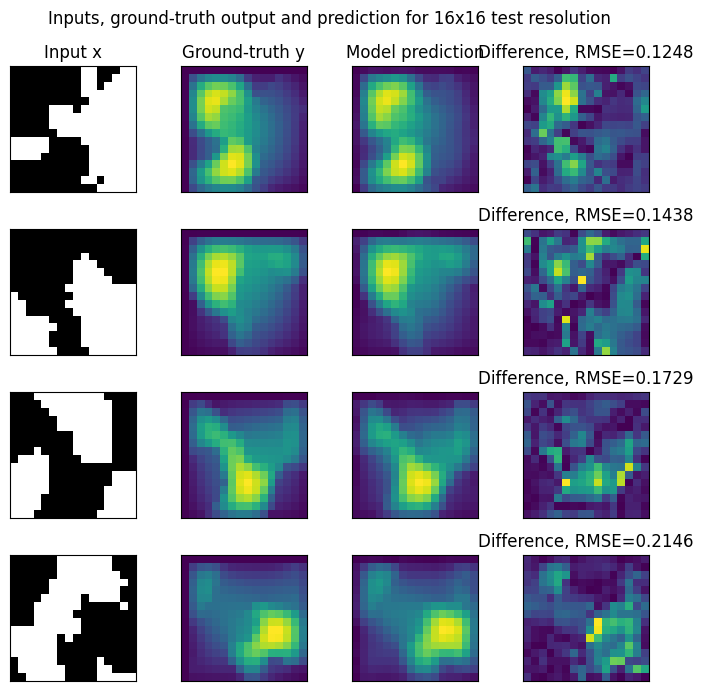

In [22]:
test_samples = FNO_test_loaders[16].dataset

FNO_model.eval()
fig = plt.figure(figsize=(7, 7))
for index in range(4):
    data = test_samples[index]
    # Input x
    x = data['x']
    print("Input tensor size:", x.size())
    # Ground-truth
    y = data['y']
    print("Ground-truth tensor size:", y.size())
    # Model prediction
    out = FNO_model(x.unsqueeze(0).to(device))
    print("Batched prediction size:", out.size())

    ax = fig.add_subplot(4, 4, index*4 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])


    ax = fig.add_subplot(4, 4, index*4 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(4, 4, index*4 + 3)
    ax.imshow(out.squeeze().detach().cpu().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(4, 4, index*4 + 4)
    ax.imshow(torch.abs((out.squeeze().detach().cpu()-(y.squeeze()-m_16)/sd_16)))
    ax.set_title('Difference, RMSE=%.4f'%torch.mean((out.squeeze().detach().cpu()-(y.squeeze()-m_16)/sd_16)**2).item()**.5)
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction for 16x16 test resolution', y=0.98)
plt.tight_layout()
fig.show()

## What about the super-resolution?

Input tensor size: torch.Size([3, 32, 32])
Ground-truth tensor size: torch.Size([1, 32, 32])
Batched prediction size: torch.Size([1, 1, 32, 32])
Input tensor size: torch.Size([3, 32, 32])
Ground-truth tensor size: torch.Size([1, 32, 32])
Batched prediction size: torch.Size([1, 1, 32, 32])
Input tensor size: torch.Size([3, 32, 32])
Ground-truth tensor size: torch.Size([1, 32, 32])
Batched prediction size: torch.Size([1, 1, 32, 32])
Input tensor size: torch.Size([3, 32, 32])
Ground-truth tensor size: torch.Size([1, 32, 32])
Batched prediction size: torch.Size([1, 1, 32, 32])


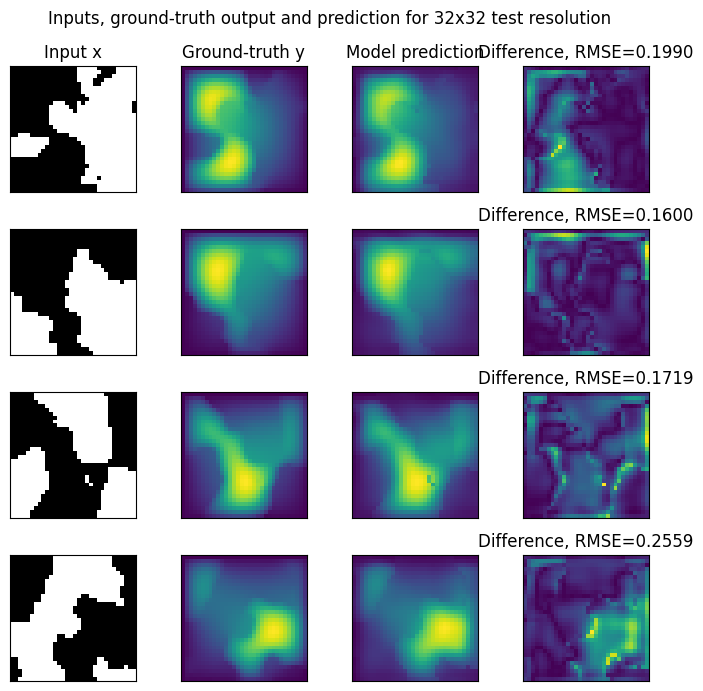

In [23]:
test_samples = FNO_test_loaders[32].dataset

FNO_model.eval()
fig = plt.figure(figsize=(7, 7))
for index in range(4):
    data = test_samples[index]
    # Input x
    x = data['x']
    print("Input tensor size:", x.size())
    # Ground-truth
    y = data['y']
    print("Ground-truth tensor size:", y.size())
    # Model prediction
    out = FNO_model(x.unsqueeze(0).to(device))
    print("Batched prediction size:", out.size())

    ax = fig.add_subplot(4, 4, index*4 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])


    ax = fig.add_subplot(4, 4, index*4 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(4, 4, index*4 + 3)
    ax.imshow(out.squeeze().detach().cpu().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(4, 4, index*4 + 4)
    ax.imshow(torch.abs((out.squeeze().detach().cpu()-(y.squeeze()-m_32)/sd_32)))
    ax.set_title('Difference, RMSE=%.4f'%torch.mean((out.squeeze().detach().cpu()-(y.squeeze()-m_32)/sd_32)**2).item()**.5)
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction for 32x32 test resolution', y=0.98)
plt.tight_layout()
fig.show()

# Questions ?